In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import plotly.graph_objects as go
from plotting import CandlePlot
import numpy as np

from simulation.grid_trade_binance import GridTradeStrategy

from functools import reduce


In [3]:

from multiprocessing import Process, Manager
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pymongo import MongoClient
import pandas as pd

# Configuração do MongoDB
client_db = MongoClient("mongodb://localhost:27017/")  # Substitua pela URI do seu banco de dados
db = client_db['trader_data']  # Nome do banco de dados

# Carregar todos os dados da coleção
def load_data_from_mongodb(symbol):
    """
    Carrega todos os dados da coleção MongoDB e converte para um DataFrame do Pandas.

    Retorna:
        pd.DataFrame: DataFrame contendo os dados carregados.
    """

    collection = db[f'seconds_{symbol}']  # Nome da coleção

    # Consultar todos os documentos na coleção
    cursor = collection.find({})
    
    # Converter os documentos em uma lista de dicionários
    data_list = list(cursor)
    
    # Criar o DataFrame a partir da lista
    df = pd.DataFrame(data_list)

    # Garantir que os campos necessários estejam presentes
    # Ajuste conforme os campos reais na coleção
    required_columns = ['close', 'high', 'low','open', 'timeframe']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"A coluna '{col}' está ausente no MongoDB.")

    # Converter a coluna de Timestamp para datetime, se necessário
    if 'timeframe' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['timeframe']):
        df['timeframe'] = pd.to_datetime(df['timeframe'], unit='s')  # Ajuste 'unit' conforme necessário

    # Ordenar os dados por Timestamp para garantir consistência
    df = df.sort_values(by='timeframe').reset_index(drop=True)

    df.rename(columns={'close': 'Close', 'high': 'High', 'low': 'Low', 'open':'Open', 'timeframe':'Time'}, inplace=True)
    
    return df


In [ ]:
# Carregar os dados
symbols = ['VIDTUSDT', 'XLMUSDT', 'ACHUSDT', 'DOTUSDT']
df_symbols = {}
for symbol in symbols:
    df_symbols[symbol] = load_data_from_mongodb(symbol)

In [ ]:
def run_pair(symbol,
             granularity,
             lenght=10000,
             strategy=1,
             tp = 0.005,
            sl = 0.005,
            movimentation = 0.01,
            grid = 0.01,
            time_in_minutes = 1,
            ):

    # Carregar os dados
    df = df_symbols[symbol]

    df['time'] = df['Time'].copy()
    df['strategy'] = 0
    # dff['returns'] = dff['Close'].pct_change()
    df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['creturns'] = df['returns'].cumsum()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['cLog_Returns'] = df['Log_Returns'].cumsum()

    # df = df.iloc[lenght:]
    df = df[df['Time'] >= lenght]
    
    df.dropna(inplace=True)
    
    df.reset_index(drop=True, inplace=True)

    gt = GridTradeStrategy(
        df,
        strategy,
        tp,
        sl,
        movimentation,
        grid,
        time_in_minutes
    )
    
    gt.run_test()
    return gt
    

In [ ]:
symbols = ["VIDTUSDT", "XLMUSDT", 'ACHUSDT', 'DOTUSDT']

granularity = "1m"

In [ ]:
# df.columns

In [ ]:
def get_list_args():
    args_dic_list = []
    for symbol in symbols:
        for granularity in ['1m']:
            for lenght in ['2024-01-01 00:00:00']:
                for strategy in [1,2]:
                    for tp in [0.01]:
                        for sl in [0.01]:
                            for movimentation in [0.02]:
                                for grid in [0.01]:
                                    for time_in_minutes in [1]:
                                        args_dic = {
                                            "symbol": symbol,
                                            "granularity": granularity,
                                            "lenght": lenght,
                                            "strategy": strategy,
                                            "tp": tp,
                                            "sl": sl,
                                            "movimentation": movimentation,
                                            "grid": grid,
                                            "time_in_minutes": time_in_minutes
                                        }
                                        args_dic_list.append(args_dic)
    return args_dic_list


In [ ]:

def run_process(L, arg):
    # print("PROCESS",arg)
    L.append(
        dict(
            arg=arg,
            symbol=arg['symbol'],
            granularity=arg['granularity'],
            lenght = arg['lenght'],
            tp = arg['tp'],
            sl = arg['sl'],
            movimentation = arg['movimentation'],
            grid = arg['grid'],
            time_in_minutes = arg['time_in_minutes'],
            res=run_pair(
                symbol=arg['symbol'],
                granularity=arg['granularity'],
                lenght = arg['lenght'],
                strategy= arg['strategy'],
                tp = arg['tp'],
                sl = arg['sl'],
                movimentation = arg['movimentation'],
                grid = arg['grid'],
                time_in_minutes = arg['time_in_minutes'],
            )
        )
    )


lista = []
def run_ema_macd():
    with Manager() as manager:
        global lista
        L = manager.list()  # Lista compartilhada entre processos
        args_list = get_list_args()
        print(len(args_list))
        limit = 10
        current = 0
    
        while current < len(args_list):
            print(current)
            processes = []
            todo = len(args_list) - current
            if todo < limit:
                limit = todo
    
            for _ in range(limit):
                processes.append(Process(target=run_process, args=(L, args_list[current])))
                current += 1
    
            for p in processes:
                p.start()
    
            for p in processes:
                p.join()

        print("ALL DONE")
        lista = list(L)

        

In [11]:
%%time

run_ema_macd()

6
0
Preparing data.
Preparing data.
Preparing data.
Preparing data.
Preparing data.
Preparing data.
running test...
running test...
running test...
running test...
running test...
running test...
ALL DONE
CPU times: user 50.8 ms, sys: 1.08 s, total: 1.13 s
Wall time: 2min 20s


In [12]:


# ddf = lista[0]['res'].df.copy()

In [13]:
# with open(f"./result-pair-trading-new-data-strategy-1-CPA-with-sl-0.05-1min-2023-to-end.pkl", "wb") as f:
#     pickle.dump(lista, f)  # Usa o pickle para salvar o arquivo



In [14]:
# cp = CandlePlot(ddf.iloc[-100000:],candles=False)


# trades_up = cp.df_plot[cp.df_plot.SIGNAL_UP == 1]

# trades_down = cp.df_plot[cp.df_plot.SIGNAL_DOWN == 1]

# print(len(trades_up),len(trades_down))

In [15]:

# marker_trade_up = '#abebc6'
# marker_trade_down = '#cccddd'


# markers = 'Close_Pair1'


# cp.add_traces(['Close_Pair1'])


# # # SIGNAL UP
# cp.fig.add_trace(go.Scatter(
#     x = trades_up.sTime,
#     y = trades_up[markers],
#     mode = 'markers',
#     marker_symbol = 'triangle-up',
#     marker=dict(color=marker_trade_up, size=12)
# ))

# cp.fig.add_trace(go.Scatter(
#     x = trades_down.sTime,
#     y = trades_down[markers],
#     mode = 'markers',
#     marker_symbol = 'triangle-down',
#     marker=dict(color=marker_trade_down, size=12)
# ))


# cp.show_plot(height=700, width=1100, sec_traces=['PCA_Index'])

In [16]:
res = lista

# with open(f"./result-binance-acumulative-percentual-new-data-strategy-14-1min-2024-split_profit.pkl", "rb") as f:
#     res = pickle.load(f)

In [17]:
res[0]['res'].len_close

847

In [18]:

dic_res = []
for r in res:

    if r['res'].len_close > 0:
        signal_up = r['res'].df_results.SIGNAL_UP.values[-1]

        res_pos_s = r['res'].df_results[r['res'].df_results['strategy'] > 0]
        res_neg_s = r['res'].df_results[r['res'].df_results['strategy'] <= 0]
        sum_neg_s = res_neg_s.strategy.sum() *-1
        sum_pos_s = res_pos_s.strategy.sum()
        dic_res.append(
            dict(
                symbol = r['symbol'],
                granularity = r['granularity'],
                strat = round(r['res'].df_results.strategy.sum(),3),
                c = r['res'].df_results['count'].mean(),
                max_o = max(r['res'].df_results.total_opened),
                st = r['res'].strategy,
                tp = r['tp'],
                sl = r['sl'],
                movimentation = r['movimentation'],
                grid = r['grid'],
                
                s_p_strat = sum_pos_s,
                s_n_strat = sum_neg_s,
                Rel_sum = sum_pos_s/(sum_pos_s+ sum_neg_s),
        
                
                l_p_strat = len(res_pos_s),
                l_n_strat = len(res_neg_s),
                Rel_len = len(res_pos_s)/(len(res_pos_s)+ len(res_neg_s)),

                l_c = r['res'].len_close,
                l_o = r['res'].len_open,
                   

                first_p = r['res'].first_price,
                last_p = r['res'].last_price,

                first_t = r['res'].df_results.start_time.values[0],
                last_t = r['res'].df_results.end_time.values[-1],
                
                r = r['res'].df_results,
                # df = r['res'].df
            )
    )
    # print(f"p={p}  e={e}  dw={dw}  dwp={dwp}   strategy={st}   result={result}")


In [19]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [20]:
df_res = pd.DataFrame(dic_res)


In [21]:
df_sorted_desc = df_res.sort_values(by=['strat'], ascending=False)

In [22]:
df_sorted_desc.columns

Index(['symbol', 'granularity', 'strat', 'c', 'max_o', 'st', 'tp', 'sl',
       'movimentation', 'grid', 's_p_strat', 's_n_strat', 'Rel_sum',
       'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o', 'first_p', 'last_p',
       'first_t', 'last_t', 'r'],
      dtype='object')

In [23]:
# Exibir todas as linhas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_sorted_desc.head(1500)[['symbol','granularity', 'strat', 'c', 'max_o', 'st', 'tp', 'sl', 'movimentation',
       'grid', 's_p_strat', 's_n_strat', 'Rel_sum', 'l_p_strat', 'l_n_strat',
       'Rel_len', 'l_c', 'l_o', 'first_p', 'last_p', 'first_t', 'last_t']]

symbol granularity  strat            c  max_o  st    tp    sl  \
2   ACHUSDT          1m -0.076  1059.749206      1   1  0.01  0.01   
4   XLMUSDT          1m -0.096   376.724739      1   1  0.01  0.01   
3   ACHUSDT          1m -0.140   153.054054      1   2  0.01  0.01   
1  VIDTUSDT          1m -0.399   123.949795      1   1  0.01  0.01   
5   XLMUSDT          1m -0.419   126.197761      1   2  0.01  0.01   
0  VIDTUSDT          1m -2.694   155.149941      1   2  0.01  0.01   

   movimentation  grid  s_p_strat  s_n_strat   Rel_sum  l_p_strat  l_n_strat  \
2           0.02  0.01   2.045898   2.122056  0.490864        144        171   
4           0.02  0.01   1.597195   1.692858  0.485462        151        136   
3           0.02  0.01   1.893520   2.033818  0.482138        160        173   
1           0.02  0.01   5.153839   5.552778  0.481369        537        439   
5           0.02  0.01   1.260152   1.679086  0.428734        131        137   
0           0.02  0.01   3.741248   6.435473  0.367628        329        518   

    Rel_len  l_c  l_o  first_p   last_p             first_t  \
2  0.457143  315    0  0.02139  0.03067 2024-01-03 11:56:04   
4  0.526132  287    0  0.12900  0.49610 2024-01-03 12:01:32   
3  0.480480  333    0  0.02139  0.03067 2024-01-03 11:56:04   
1  0.550205  976    0  0.02813  0.04219 2024-01-03 12:07:34   
5  0.488806  268    0  0.12900  0.49610 2024-01-03 12:01:32   
0  0.388430  847    0  0.02813  0.04219 2024-01-03 12:07:34   

               last_t  
2 2024-11-24 05:10:30  
4 2024-11-30 00:30:06  
3 2024-11-24 04:17:54  
1 2024-11-23 16:25:18  
5 2024-11-30 00:30:12  
0 2024-11-23 16:25:32

symbol granularity  strat           c  max_o  st     tp     sl  \
0  VIDTUSDT          1m  2.419   60.107509      1   1  0.005  0.005   
2   ACHUSDT          1m  0.895   66.964103      1   2  0.005  0.005   
3   ACHUSDT          1m  0.787  163.263039      1   1  0.005  0.005   
5   XLMUSDT          1m  0.442   51.525974      1   2  0.005  0.005   
1  VIDTUSDT          1m  0.253   86.678535      1   2  0.005  0.005   
4   XLMUSDT          1m  0.151   60.824047      1   1  0.005  0.005   

   movimentation  grid  s_p_strat  s_n_strat   Rel_sum  l_p_strat  l_n_strat  \
0           0.02  0.01   5.166518   2.747881  0.652800        671        501   
2           0.02  0.01   2.012838   1.117919  0.642924        190        200   
3           0.02  0.01   1.970961   1.183600  0.624797        230        211   
5           0.02  0.01   1.236133   0.793838  0.608941        165        143   
1           0.02  0.01   3.484384   3.231688  0.518813        409        574   
4           0.02  0.01   1.166473   1.015495  0.534597        159        182   

    Rel_len   l_c  l_o  first_p   last_p             first_t  \
0  0.572526  1172    0  0.02813  0.04219 2024-01-03 12:07:34   
2  0.487179   390    0  0.02139  0.03067 2024-01-03 11:56:04   
3  0.521542   441    0  0.02139  0.03067 2024-01-03 11:56:04   
5  0.535714   308    0  0.12900  0.49610 2024-01-03 12:01:32   
1  0.416073   983    0  0.02813  0.04219 2024-01-03 12:07:34   
4  0.466276   341    0  0.12900  0.49610 2024-01-03 12:01:32   

               last_t  
0 2024-11-23 16:25:18  
2 2024-11-24 04:17:54  
3 2024-11-24 05:26:48  
5 2024-11-30 00:17:10  
1 2024-11-23 16:25:18  
4 2024-11-30 00:17:22

symbol granularity  strat          c  max_o  st     tp     sl  \
0  VIDTUSDT          1m  1.107  62.117081      1   1  0.005  0.005   
1   ACHUSDT          1m  0.041  16.225045      1   1  0.005  0.005   
2   XLMUSDT          1m -0.187  48.631841      1   1  0.005  0.005   

   movimentation  grid  s_p_strat  s_n_strat   Rel_sum  l_p_strat  l_n_strat  \
0           0.02  0.01   3.081656   1.974240  0.609517        464        783   
1           0.02  0.01   0.963153   0.921888  0.510945        194        357   
2           0.02  0.01   0.680640   0.867590  0.439624        144        258   

    Rel_len   l_c  l_o  first_p   last_p             first_t  \
0  0.372093  1247    0  0.02813  0.04219 2024-01-03 12:07:34   
1  0.352087   551    0  0.02139  0.03067 2024-01-03 11:56:04   
2  0.358209   402    0  0.12900  0.49610 2024-01-03 12:01:32   

               last_t  
0 2024-11-23 16:25:16  
1 2024-11-24 04:17:16  
2 2024-11-30 00:17:30

symbol granularity  strat           c  max_o  st     tp     sl  \
1   ACHUSDT          1m  0.611  597.471861      1   1  0.005  0.005   
2   XLMUSDT          1m -0.195   82.447222      1   1  0.005  0.005   
0  VIDTUSDT          1m -0.655   35.817315      1   1  0.005  0.005   

   movimentation  grid  s_p_strat  s_n_strat   Rel_sum  l_p_strat  l_n_strat  \
1           0.02  0.01   1.501516   0.890867  0.627623        128        334   
2           0.02  0.01   0.605992   0.801231  0.430630        110        250   
0           0.02  0.01   1.809128   2.463998  0.423373        248       1011   

    Rel_len   l_c  l_o  first_p   last_p             first_t  \
1  0.277056   462    0  0.02139  0.03067 2024-01-03 11:56:04   
2  0.305556   360    0  0.12900  0.49610 2024-01-03 12:01:32   
0  0.196982  1259    0  0.02813  0.04219 2024-01-03 12:07:34   

               last_t  
1 2024-11-24 04:17:14  
2 2024-11-30 00:17:06  
0 2024-11-23 16:25:16

symbol granularity  strat           c  max_o  st    tp    sl  \
1   ACHUSDT          1m  0.541  813.366391      1   1  0.01  0.01   
2   XLMUSDT          1m -0.275   60.993127      1   1  0.01  0.01   
0  VIDTUSDT          1m -1.687  154.368049      1   1  0.01  0.01   

   movimentation  grid  s_p_strat  s_n_strat   Rel_sum  l_p_strat  l_n_strat  \
1           0.02  0.01   2.102893   1.561664  0.573847        152        211   
2           0.02  0.01   1.170401   1.445464  0.447424        133        158   
0           0.02  0.01   3.023426   4.710912  0.390909        315        674   

    Rel_len  l_c  l_o  first_p   last_p             first_t  \
1  0.418733  363    0  0.02139  0.03067 2024-01-03 11:56:04   
2  0.457045  291    0  0.12900  0.49610 2024-01-03 12:01:32   
0  0.318504  989    0  0.02813  0.04219 2024-01-03 12:07:34   

               last_t  
1 2024-11-24 04:19:32  
2 2024-11-30 00:30:12  
0 2024-11-23 16:25:16

symbol granularity  strat           c  max_o  st    tp    sl  \
0  VIDTUSDT          1m  0.990  125.099415      1   1  0.01  0.01   
2   XLMUSDT          1m -0.140  162.699029      1   1  0.01  0.01   
1   ACHUSDT          1m -0.246  353.450122      1   1  0.01  0.01   

   movimentation  grid  s_p_strat  s_n_strat   Rel_sum  l_p_strat  l_n_strat  \
0           0.02  0.01   4.571261   3.581538  0.560698        498        528   
2           0.02  0.01   1.343260   1.483399  0.475211        139        170   
1           0.02  0.01   1.716101   1.962253  0.466540        160        251   

    Rel_len   l_c  l_o  first_p   last_p             first_t  \
0  0.485380  1026    0  0.02813  0.04219 2024-01-03 12:07:34   
2  0.449838   309    0  0.12900  0.49610 2024-01-03 12:01:32   
1  0.389294   411    0  0.02139  0.03067 2024-01-03 11:56:04   

               last_t  
0 2024-11-23 16:25:16  
2 2024-11-30 00:30:04  
1 2024-11-24 04:17:16

In [235]:
df_ = df_res.iloc[0].r
df_.head()

running    tp    sl  start_index_m5  count  trigger_type  strategy  \
0    False  0.01  0.01            2579    133             0 -0.011000   
1    False  0.01  0.01            7910     21             0 -0.011000   
2    False  0.01  0.01            7931      9             0 -0.009308   
3    False  0.01  0.01            7941     13             0 -0.011000   
4    False  0.01  0.01            7954      6             0 -0.011000   

   strategy_no_tc  total_opened  first_return  trail_stop_trigger  \
0               0             1         False                   0   
1               0             1         False                   0   
2               0             1         False                   0   
3               0             1         False                   0   
4               0             1         False                   0   

   trailing_stop_target  trailing_stop_loss  stop_loss type  start_price  \
0                  0.01               -0.01      -0.03  buy      0.02975   
1                  0.01               -0.01      -0.03  buy      0.02813   
2                  0.01               -0.01      -0.03  buy      0.02780   
3                  0.01               -0.01      -0.03  buy      0.02751   
4                  0.01               -0.01      -0.03  buy      0.02714   

   trigger_price  SIGNAL_UP  SIGNAL_DOWN   result            end_time  \
0        0.02943          1            0 -0.00032 2024-01-01 20:25:26   
1        0.02785          1            0 -0.00028 2024-01-03 12:08:46   
2        0.02757          1            0 -0.00023 2024-01-03 12:09:20   
3        0.02722          1            0 -0.00029 2024-01-03 12:09:58   
4        0.02650          1            0 -0.00064 2024-01-03 12:10:20   

           start_time  
0 2024-01-01 19:53:42  
1 2024-01-03 12:07:32  
2 2024-01-03 12:08:48  
3 2024-01-03 12:09:24  
4 2024-01-03 12:10:02

In [236]:
# df_sorted_desc.iloc[4].r['time'] = df_sorted_desc.iloc[4].r['end_time']
# df_sorted_desc.iloc[4].r['GAIN_C'] = df_sorted_desc.iloc[4].r.strategy.cumsum()

# cp = CandlePlot(df_sorted_desc.iloc[4].r, candles=False)
# cp.show_plot(line_traces = ['GAIN_C'])

In [21]:
def rank_backtest_results(df):
    # Definindo pesos para cada coluna com base na importância
    weights = {
        'strat': 0.4,           # Retorno acumulado percentual (maximizar)
        'Rel_sum': 0.2,        # Relação de resultados positivos/negativos (maximizar)
    }
    
    # Normalizando as colunas relevantes
    for col in weights.keys():
        df[col + '_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    # Calculando o score ponderado para cada linha
    df['score'] = sum(
        df[col + '_norm'] * weight if weight >= 0 else (1 - df[col + '_norm']) * abs(weight) 
        for col, weight in weights.items()
    )
    
    # Ordenando o DataFrame pelos melhores resultados com base no score
    df_sorted = df.sort_values(by='score', ascending=False).reset_index(drop=True)
    
    # Removendo colunas de normalização temporárias
    df_sorted.drop(columns=[col + '_norm' for col in weights.keys()], inplace=True)
    
    return df_sorted

In [22]:
# pairs = ['DOTUSDT','DOGEUSDT','ADAUSDT','XRPUSDT','TRXUSDT','XLMUSDT','APTUSDT','VIDTUSDT','BTCUSDT',
#           'ETHUSDT','AVAXUSDT','BNBUSDT','LTCUSDT','LINKUSDT',
#          'BCHUSDT','EOSUSDT','ETCUSDT','DASHUSDT','ALGOUSDT','SANDUSDT',
#          'ARUSDT', 'INJUSDT', 'MASKUSDT', 'CELOUSDT', 'BANDUSDT', 'ALPHAUSDT', 'PERPUSDT',
#          'ACHUSDT', 'CHRUSDT', 'BELUSDT']
pairs = ['VIDTUSDT', 'XLMUSDT', 'ACHUSDT']

In [23]:
# df_APTUSDT = df_res[df_res['pair']=='APTUSDT']
# df_DOTUSDT = df_res[df_res['pair']=='DOTUSDT']
# df_DOGEUSDT = df_res[df_res['pair']=='DOGEUSDT']
# df_ADAUSDT = df_res[df_res['pair']=='ADAUSDT']
# df_XRPUSDT = df_res[df_res['pair']=='XRPUSDT']
# df_VIDTUSDT = df_res[df_res['pair']=='VIDTUSDT']
# df_TRXUSDT = df_res[df_res['pair']=='TRXUSDT']
# df_XLMUSDT = df_res[df_res['pair']=='XLMUSDT']

In [24]:
# rank_APT = rank_backtest_results(df_APTUSDT)
# rank_DOT = rank_backtest_results(df_DOTUSDT)
# rank_DOGE = rank_backtest_results(df_DOGEUSDT)
# rank_ADA = rank_backtest_results(df_ADAUSDT)
# rank_XRP = rank_backtest_results(df_XRPUSDT)
# rank_VIDT = rank_backtest_results(df_VIDTUSDT)
# rank_TRX = rank_backtest_results(df_TRXUSDT)
# rank_XLM = rank_backtest_results(df_XLMUSDT)



In [25]:
# Lista de pares
# pairs = ['DOTUSDT','DOGEUSDT','ADAUSDT','XRPUSDT','TRXUSDT','XLMUSDT','APTUSDT','VIDTUSDT','BTCUSDT',
#          'ETHUSDT','AVAXUSDT','BNBUSDT','LTCUSDT','LINKUSDT',
#          'BCHUSDT','EOSUSDT','ETCUSDT','DASHUSDT','ALGOUSDT','SANDUSDT',
#          'ARUSDT', 'INJUSDT', 'MASKUSDT', 'CELOUSDT', 'BANDUSDT', 'ALPHAUSDT', 'PERPUSDT',
#          'ACHUSDT', 'CHRUSDT', 'BELUSDT']

# Dicionários para armazenar DataFrames e ranks
df_dict = {}
rank_dict = {}

# Loop para criar DataFrames e calcular ranks
for pair in pairs:
    df_dict[pair] = df_res[df_res['symbol'] == pair]
    # df_dict[pair] = df_res
    rank_dict[pair] = rank_backtest_results(df_dict[pair])



In [26]:
# Exemplo de como acessar os resultados
df_dict['VIDTUSDT'].columns  # DataFrame do par DOTUSDT


Index(['symbol', 'granularity', 'strat', 'c', 'max_o', 'st', 'tp', 'sl',
       'movimentation', 'grid', 's_p_strat', 's_n_strat', 'Rel_sum',
       'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o', 'first_p', 'last_p',
       'first_t', 'last_t', 'r', 'strat_norm', 'Rel_sum_norm', 'score'],
      dtype='object')

In [27]:
mean_dict = []
for pair in pairs:
    dic_ = {
        "pair": pair,
        "strat": round(rank_dict[pair].strat.mean(),2),
        "rel_sum": round(rank_dict[pair].Rel_sum.mean(),2)
    }
    mean_dict.append(dic_)
    
df_mean = pd.DataFrame(mean_dict)

df_mean = df_mean.sort_values(by='strat', ascending=False).reset_index(drop=True)
df_mean

pair  strat  rel_sum
0  VIDTUSDT   1.34     0.59
1   ACHUSDT   0.84     0.63
2   XLMUSDT   0.30     0.57

In [28]:
rank_dict['VIDTUSDT'] = rank_dict['VIDTUSDT'].round(2)
rank_dict['VIDTUSDT'].head(350)[['granularity', 'strat', 'c', 'max_o', 'st', 'tp', 'sl', 'movimentation',
       'grid', 's_p_strat', 's_n_strat', 'Rel_sum', 'l_p_strat', 'l_n_strat',
       'Rel_len', 'l_c', 'l_o', 'first_p', 'last_p', 'first_t', 'last_t']]

granularity  strat      c  max_o  st   tp   sl  movimentation  grid  \
0          1m   2.42  60.11      1   1  0.0  0.0           0.02  0.01   
1          1m   0.25  86.68      1   2  0.0  0.0           0.02  0.01   

   s_p_strat  s_n_strat  Rel_sum  l_p_strat  l_n_strat  Rel_len   l_c  l_o  \
0       5.17       2.75     0.65        671        501     0.57  1172    0   
1       3.48       3.23     0.52        409        574     0.42   983    0   

   first_p  last_p             first_t              last_t  
0     0.03    0.04 2024-01-03 12:07:34 2024-11-23 16:25:18  
1     0.03    0.04 2024-01-03 12:07:34 2024-11-23 16:25:18

In [29]:
# rank_dict['XLMUSDT'] = rank_dict['XLMUSDT'].round(2)
# rank_dict['XLMUSDT'].head(350)[['pair1', 'strat', 'c', 'max_o',
#        'entry_threshold','exit_threshold','window', 's_p_strat', 's_n_strat',
#        'Rel_sum', 'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o']]

In [30]:
# rank_dict['ALPHAUSDT'] = rank_dict['ALPHAUSDT'].round(2)
# rank_dict['ALPHAUSDT'].head(350)[['pair1', 'strat', 'c', 'max_o',
#        'entry_threshold','exit_threshold','window', 's_p_strat', 's_n_strat',
#        'Rel_sum', 'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o']]

In [31]:
# rank_dict['DASHUSDT'] = rank_dict['DASHUSDT'].round(2)
# rank_dict['DASHUSDT'].head(350)[['pair1', 'strat', 'c', 'max_o',
#        'entry_threshold','exit_threshold','window', 's_p_strat', 's_n_strat',
#        'Rel_sum', 'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o']]

In [32]:
def get_daily_operations_with_strategy(df):
    """
    Retorna um novo DataFrame com a quantidade de operações por dia e o total da soma da coluna 'strategy_pair1'.
    
    :param df: DataFrame original com as colunas 'start_time' e 'strategy_pair1'.
    :return: DataFrame com a contagem de operações por dia e o total de 'strategy_pair1' por dia.
    """
    # Criar uma cópia do DataFrame original para não alterá-lo
    df_copy = df.copy()
    
    # Converter a coluna 'start_time' para o formato datetime, se necessário
    df_copy['start_time'] = pd.to_datetime(df_copy['start_time'])
    
    # Criar uma nova coluna com apenas a data
    df_copy['time'] = df_copy['start_time'].dt.date
    
    # Agrupar por data e calcular a quantidade de operações e soma de 'strategy_pair1'
    daily_operations = df_copy.groupby('time').agg(
        operation_count=('start_time', 'size'),
        total_strategy=('strategy', 'sum')
    ).reset_index()
    
    return daily_operations


# VIDT USDT

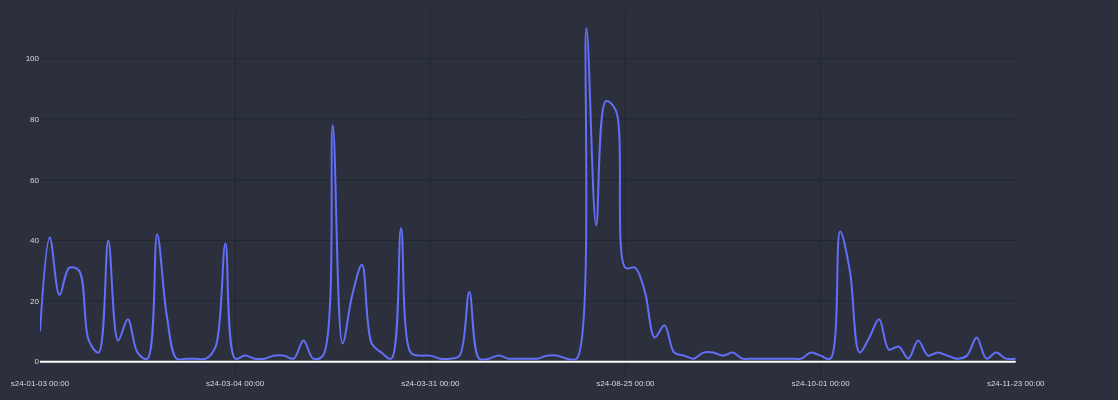

In [33]:
df_op = get_daily_operations_with_strategy(rank_dict['VIDTUSDT'].iloc[0].r)
cp = CandlePlot(df_op, candles=False)
cp.show_plot(line_traces = ['operation_count'])

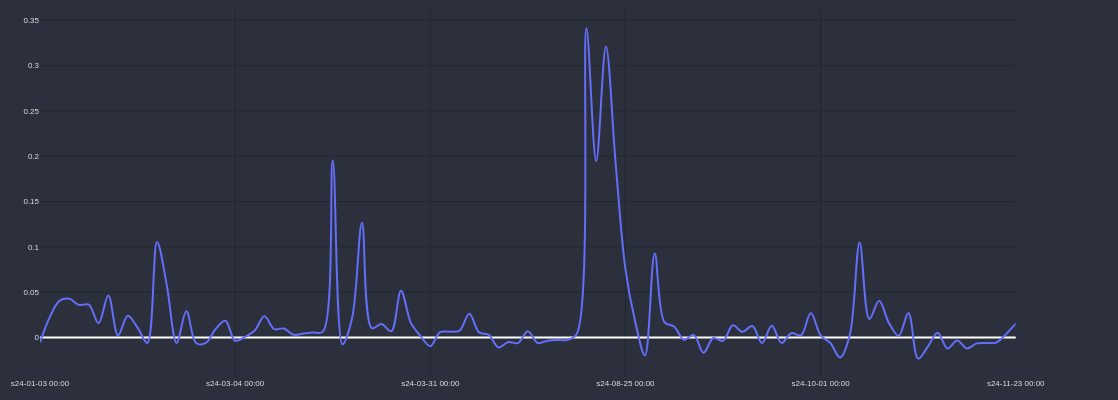

In [34]:
df_op = get_daily_operations_with_strategy(rank_dict['VIDTUSDT'].iloc[0].r)
cp = CandlePlot(df_op, candles=False)
cp.show_plot(line_traces = ['total_strategy'])

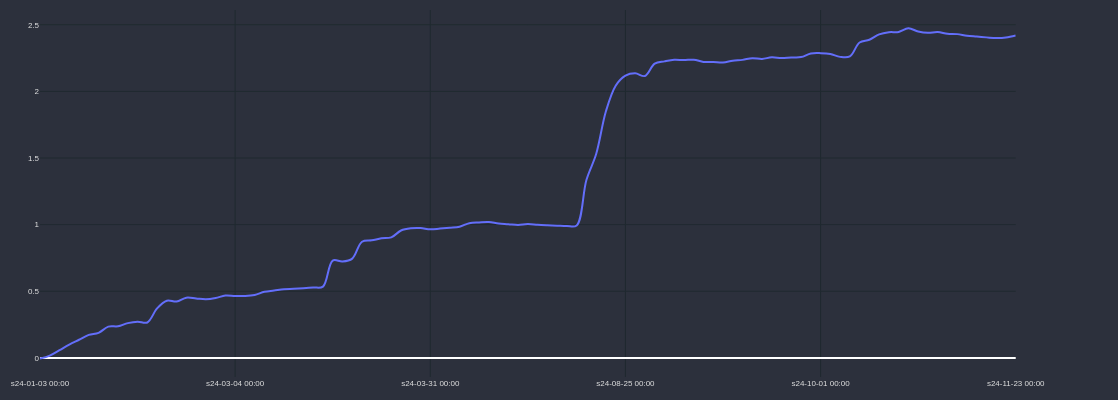

In [35]:
df_op = get_daily_operations_with_strategy(rank_dict['VIDTUSDT'].iloc[0].r)
df_op['total_strategy_sum'] = df_op.total_strategy.cumsum()
cp = CandlePlot(df_op, candles=False)
cp.show_plot(line_traces = ['total_strategy_sum'])

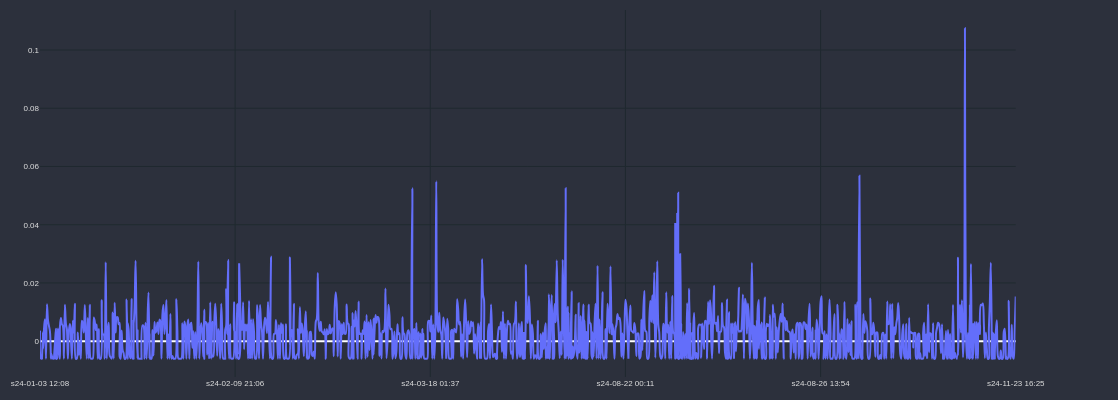

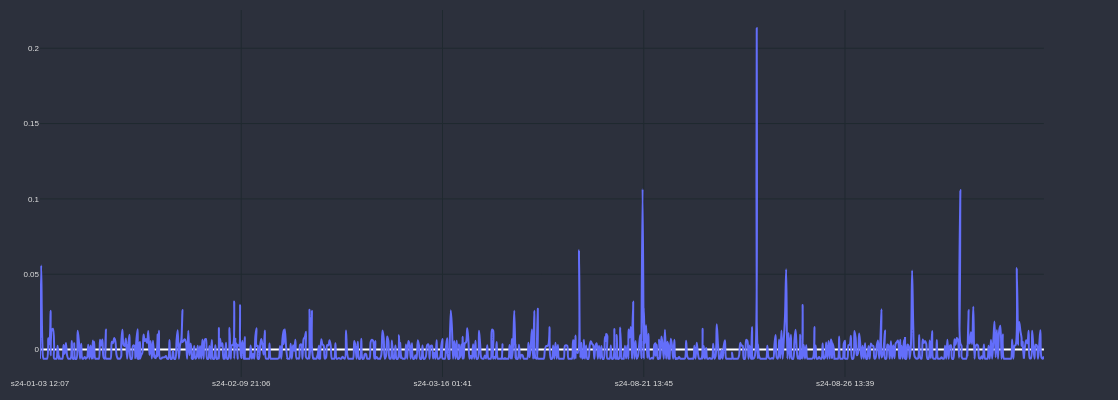

In [36]:
for index in range(len(rank_dict['VIDTUSDT'])):
    rank = rank_dict['VIDTUSDT'].iloc[index]
    rank.r['time'] = rank.r['end_time']
    rank.r['GAIN_I'] = rank.r.strategy

    cp = CandlePlot(rank.r, candles=False)
    cp.show_plot(line_traces = ['GAIN_I'])

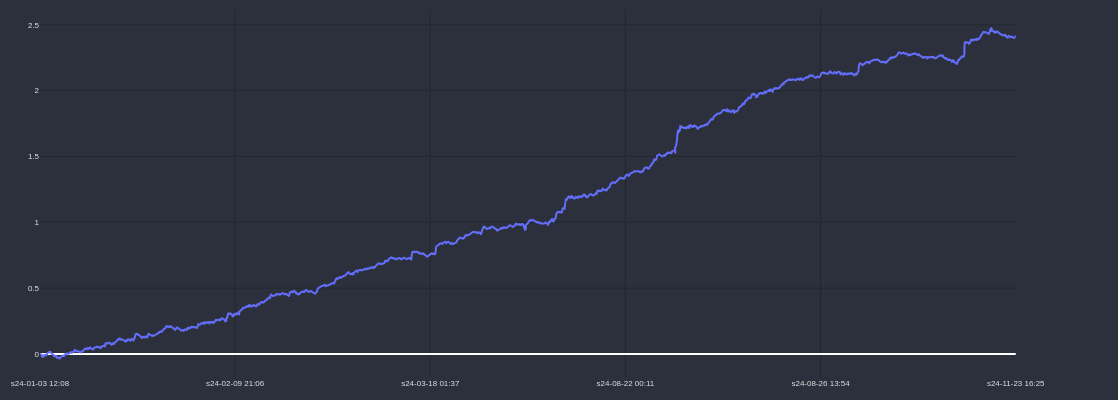

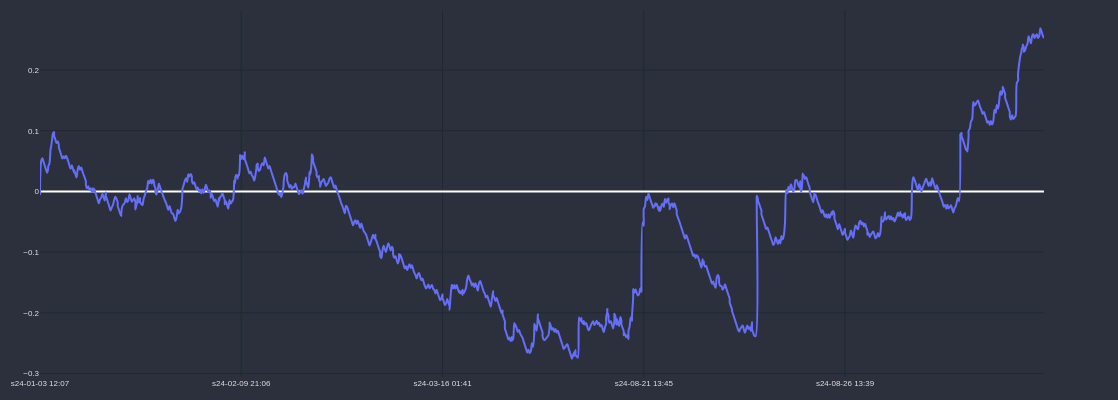

In [37]:
for index in range(len(rank_dict['VIDTUSDT'])):
    rank = rank_dict['VIDTUSDT'].iloc[index]
    rank.r['time'] = rank.r['end_time']
    rank.r['GAIN_I'] = rank.r.strategy.cumsum()

    cp = CandlePlot(rank.r, candles=False)
    cp.show_plot(line_traces = ['GAIN_I'])

# Alpha ACHUSDT

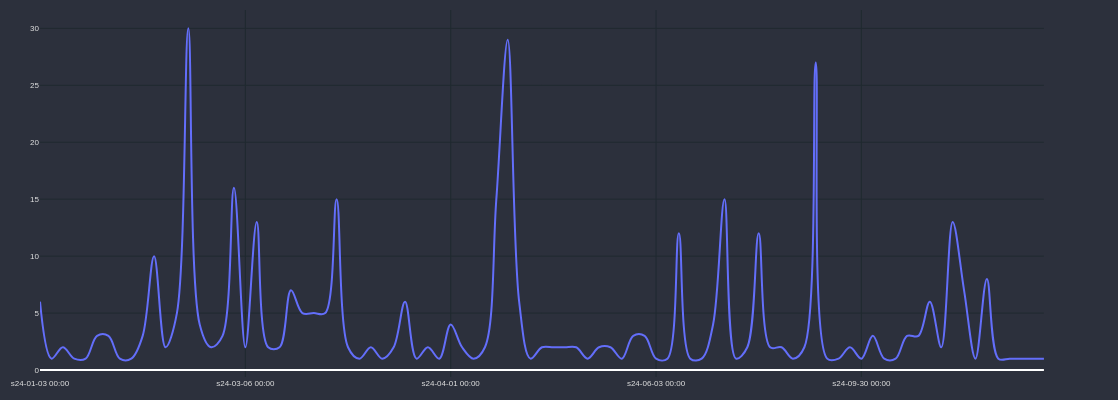

In [38]:
df_op = get_daily_operations_with_strategy(rank_dict['ACHUSDT'].iloc[0].r)
cp = CandlePlot(df_op, candles=False)
cp.show_plot(line_traces = ['operation_count'])

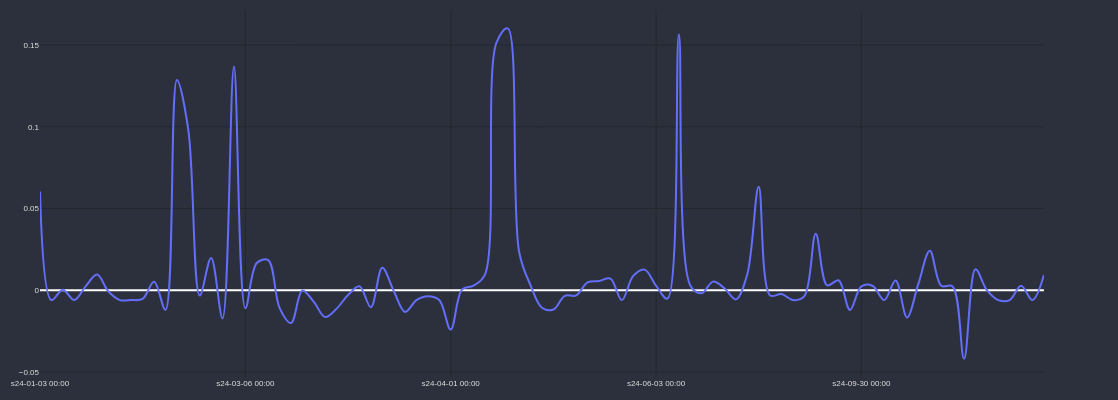

In [39]:
df_op = get_daily_operations_with_strategy(rank_dict['ACHUSDT'].iloc[0].r)
cp = CandlePlot(df_op, candles=False)
cp.show_plot(line_traces = ['total_strategy'])

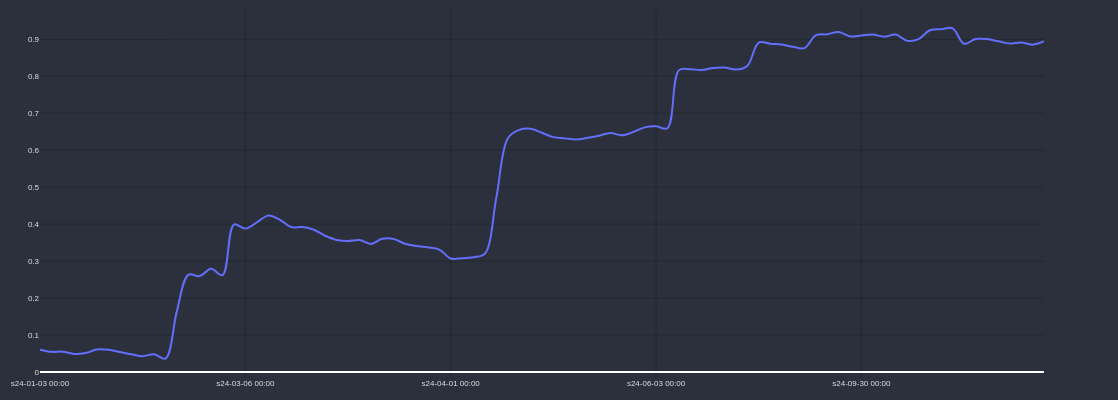

In [40]:
df_op = get_daily_operations_with_strategy(rank_dict['ACHUSDT'].iloc[0].r)
df_op['total_strategy_sum'] = df_op.total_strategy.cumsum()
cp = CandlePlot(df_op, candles=False)
cp.show_plot(line_traces = ['total_strategy_sum'])

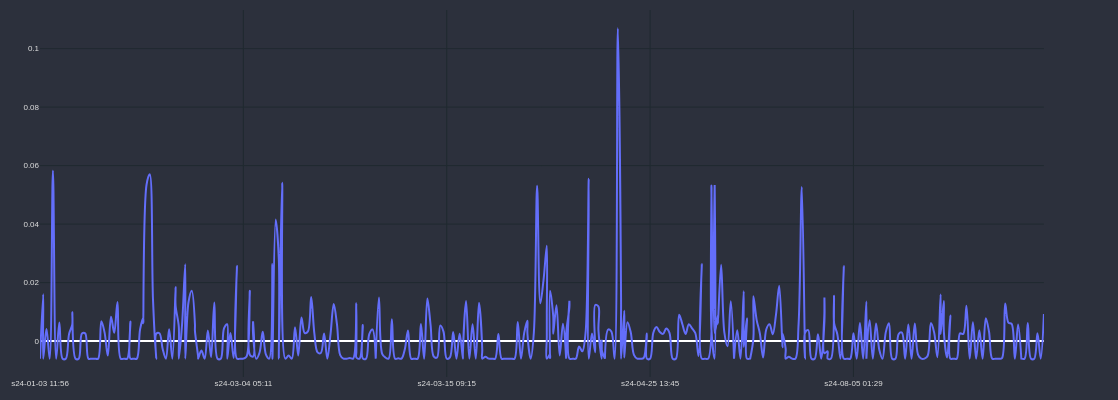

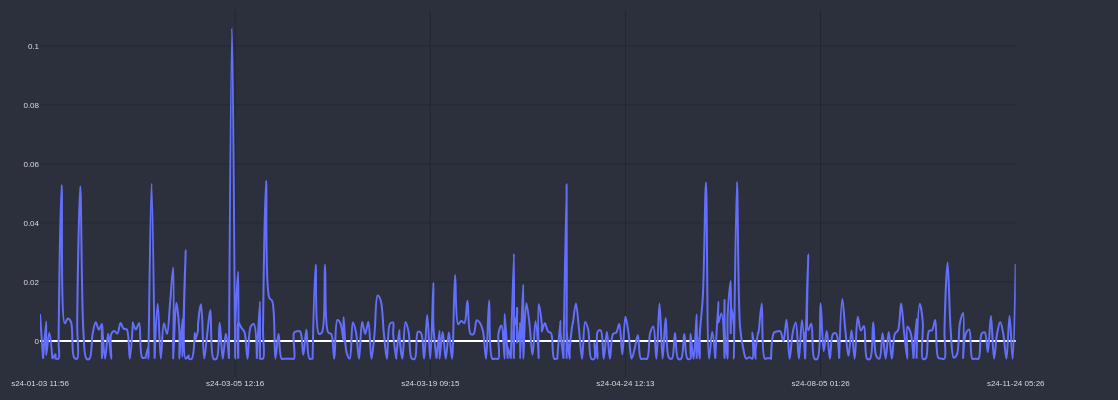

In [41]:
for index in range(len(rank_dict['ACHUSDT'])):
    rank = rank_dict['ACHUSDT'].iloc[index]
    rank.r['time'] = rank.r['end_time']
    rank.r['GAIN_I'] = rank.r.strategy

    cp = CandlePlot(rank.r, candles=False)
    cp.show_plot(line_traces = ['GAIN_I'])

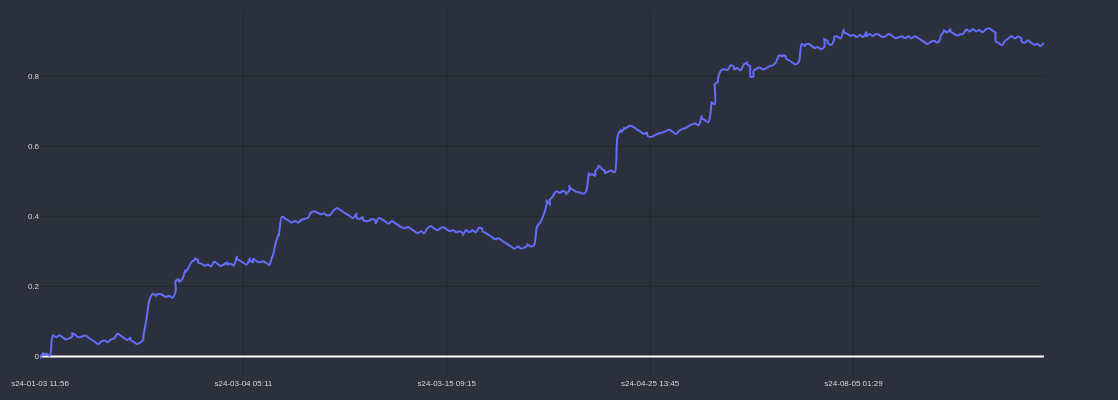

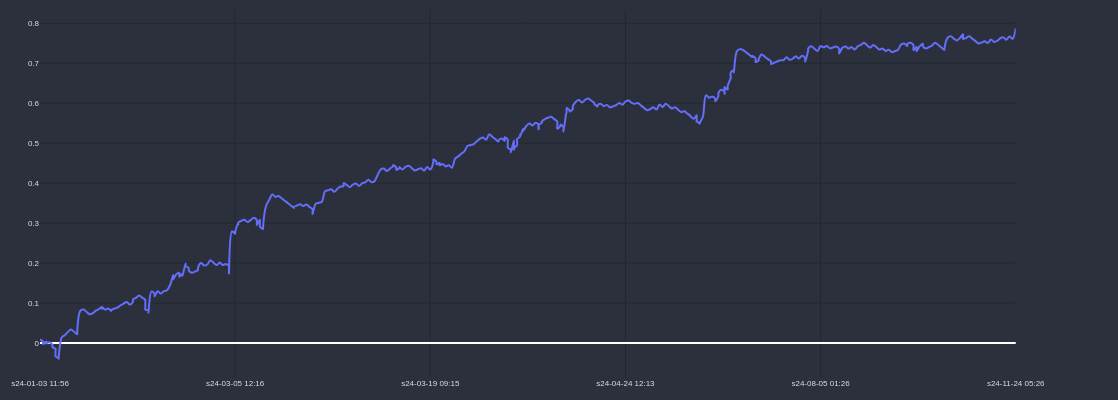

In [42]:
for index in range(len(rank_dict['ACHUSDT'])):
    rank = rank_dict['ACHUSDT'].iloc[index]
    rank.r['time'] = rank.r['end_time']
    rank.r['GAIN_I'] = rank.r.strategy.cumsum()

    cp = CandlePlot(rank.r, candles=False)
    cp.show_plot(line_traces = ['GAIN_I'])

# XML USDT

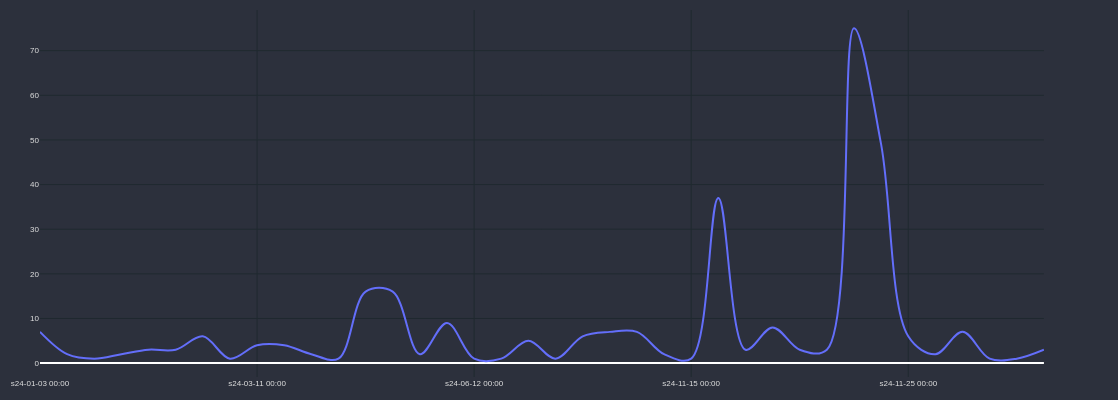

In [43]:
df_op = get_daily_operations_with_strategy(rank_dict['XLMUSDT'].iloc[0].r)
cp = CandlePlot(df_op, candles=False)
cp.show_plot(line_traces = ['operation_count'])

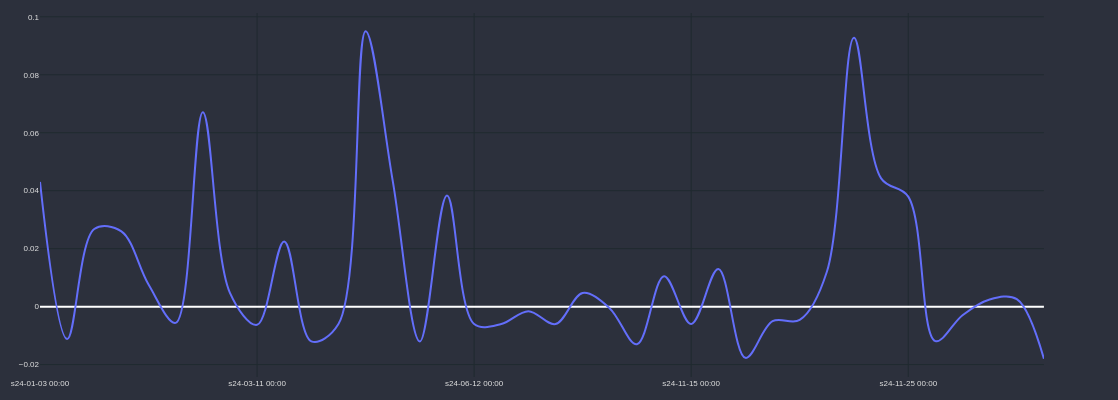

In [44]:
df_op = get_daily_operations_with_strategy(rank_dict['XLMUSDT'].iloc[0].r)
cp = CandlePlot(df_op, candles=False)
cp.show_plot(line_traces = ['total_strategy'])

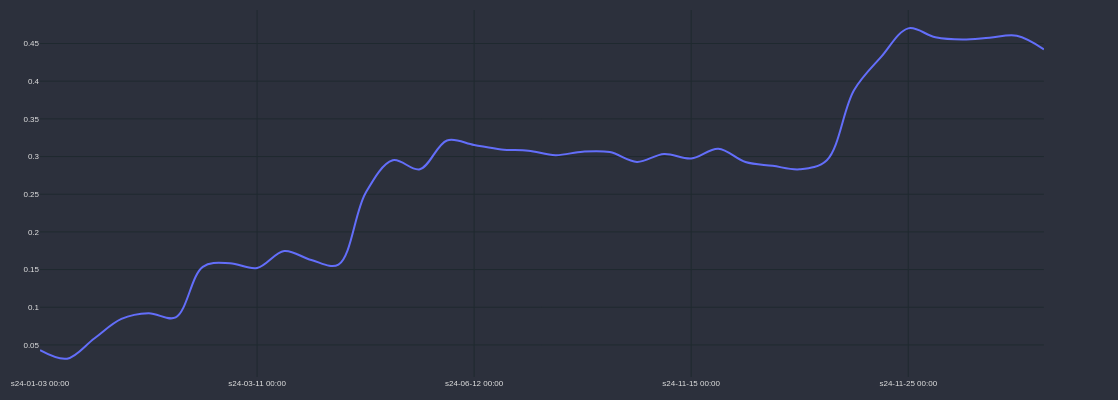

In [45]:
df_op = get_daily_operations_with_strategy(rank_dict['XLMUSDT'].iloc[0].r)
df_op['total_strategy_sum'] = df_op.total_strategy.cumsum()
cp = CandlePlot(df_op, candles=False)
cp.show_plot(line_traces = ['total_strategy_sum'])

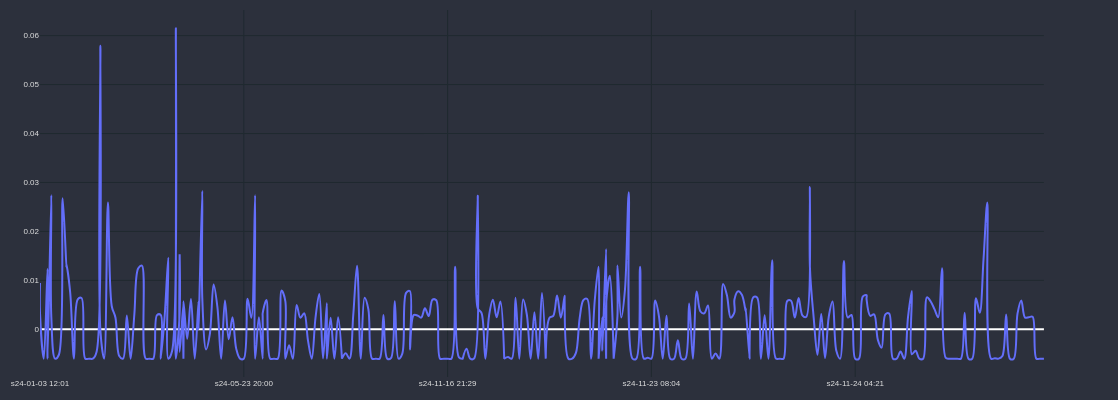

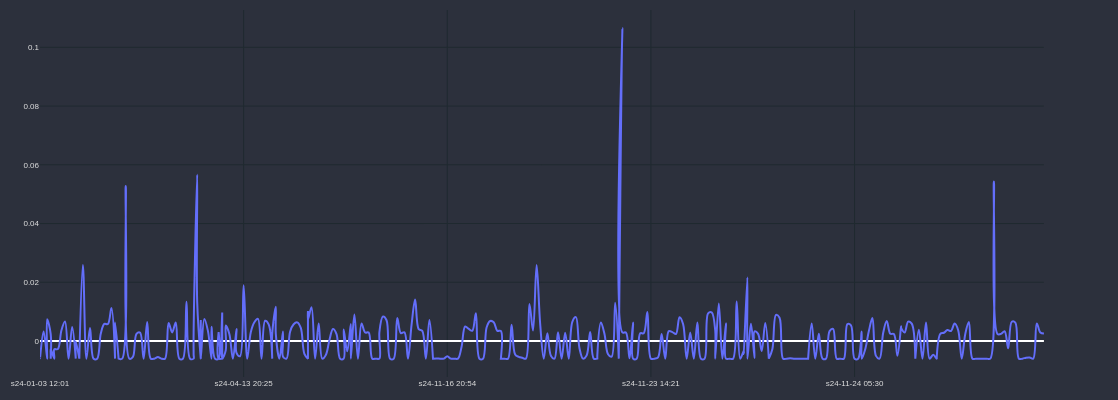

In [46]:
for index in range(len(rank_dict['XLMUSDT'])):
    rank = rank_dict['XLMUSDT'].iloc[index]
    rank.r['time'] = rank.r['end_time']
    rank.r['GAIN_I'] = rank.r.strategy

    cp = CandlePlot(rank.r, candles=False)
    cp.show_plot(line_traces = ['GAIN_I'])

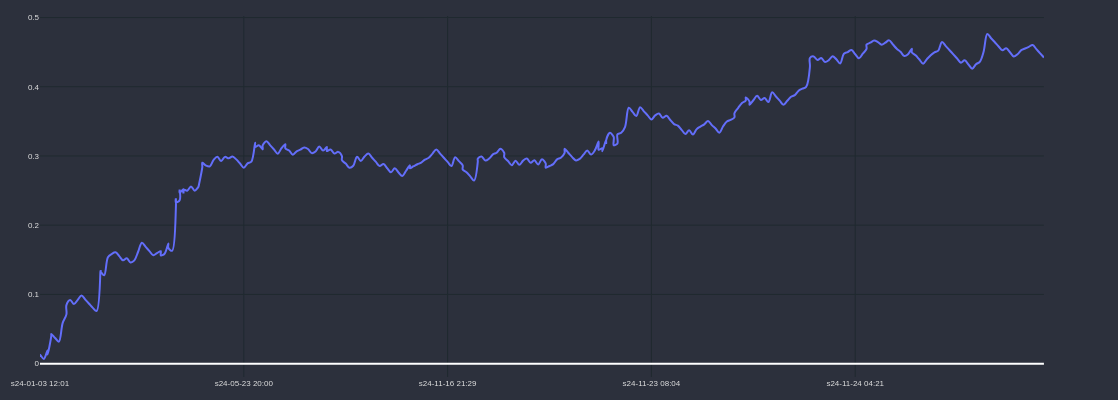

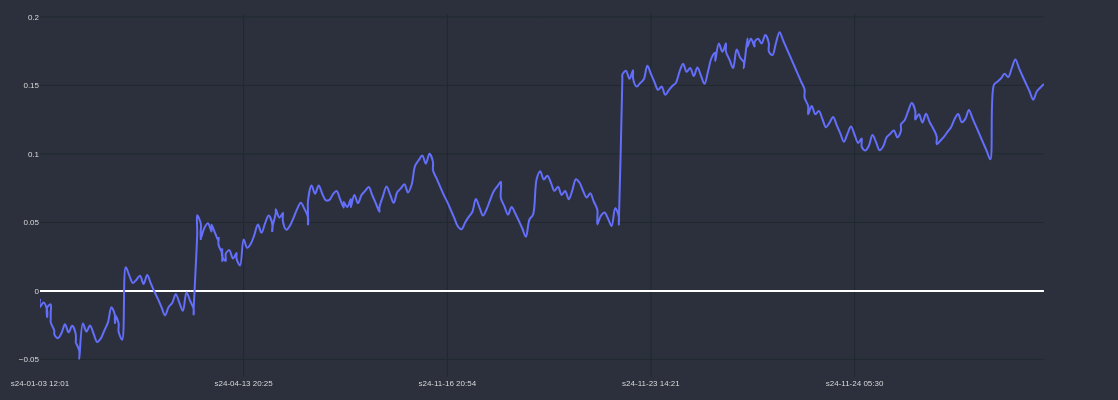

In [47]:
for index in range(len(rank_dict['XLMUSDT'])):
    rank = rank_dict['XLMUSDT'].iloc[index]
    rank.r['time'] = rank.r['end_time']
    rank.r['GAIN_I'] = rank.r.strategy.cumsum()

    cp = CandlePlot(rank.r, candles=False)
    cp.show_plot(line_traces = ['GAIN_I'])

In [93]:
def calcular_operacoes_simultaneas(df):
    # Ordena o DataFrame por start_time para facilitar o cálculo
    df = df.sort_values(by='start_time').reset_index(drop=True)
    # Inicializa a coluna operacoes_simultaneas com o valor mínimo de 0
    df['operacoes_simultaneas'] = 0
    
    # Itera sobre cada operação e conta quantas estão abertas e não fechadas no momento
    for i, row in df.iterrows():
        # Conta quantas operações estão em andamento no tempo de start_time da operação atual
        count = ((df['start_time'] <= row['start_time']) & (df['end_time'] > row['start_time'])).sum()
        # Atualiza a coluna com o número de operações simultâneas, garantindo o mínimo de 1
        df.at[i, 'operacoes_simultaneas'] = max(count, 1)
        
    return df

In [95]:

# # Concatenar os DataFrames filtrados, acessando os 10 primeiros elementos do atributo `r` de cada um
# concat_ranks = pd.concat(
#     [
#         rank_dict['VIDTUSDT'].iloc[index].r for index in range(1)
#     ]
# )


# Concatenar os DataFrames filtrados, acessando os 10 primeiros elementos do atributo `r` de cada um
concat_ranks = pd.concat(
    [
        rank_dict['VIDTUSDT'].iloc[0].r,
        # rank_dict['XLMUSDT'].iloc[0].r,
        # rank_dict['ALPHAUSDT'].iloc[0].r,
        # rank_dict['DASHUSDT'].iloc[0].r 
    ]
)


In [96]:
concat_ranks.shape

(1184, 24)

In [97]:
concat_ranks.strategy.sum()

np.float64(0.9546989974208434)

In [98]:
df_test = calcular_operacoes_simultaneas(concat_ranks)
df_test.operacoes_simultaneas.max()

np.int64(1)

In [99]:
df_test.tail()

running     tp     sl  start_index_m5  count  trigger_type  strategy  \
1179    False  0.003  0.005         2572126      1             0 -0.001000   
1180    False  0.003  0.005         2590547     18             0  0.004057   
1181    False  0.003  0.005         2590592     28             0 -0.006000   
1182    False  0.003  0.005         2591446     11             0 -0.006000   
1183    False  0.003  0.005         2705779     10             0  0.001397   

      strategy_no_tc  total_opened  first_return  trail_stop_trigger  \
1179               0             1         False                   0   
1180               0             1         False                   1   
1181               0             1         False                   0   
1182               0             1         False                   0   
1183               0             1         False                   1   

      trailing_stop_target  trailing_stop_loss  stop_loss  type  start_price  \
1179                 0.003           -0.005000      -0.03   buy      0.03173   
1180                 0.012            0.005057      -0.03   buy      0.03283   
1181                 0.003           -0.005000      -0.03  sell      0.03359   
1182                 0.003           -0.005000      -0.03  sell      0.03218   
1183                 0.006            0.002395      -0.03   buy      0.03334   

      trigger_price  SIGNAL_UP  SIGNAL_DOWN   result            end_time  \
1179        0.03173          1            0  0.00000 2024-11-10 21:02:48   
1180        0.03295          1            0  0.00012 2024-11-12 10:07:16   
1181        0.03378          0            1 -0.00019 2024-11-12 10:09:30   
1182        0.03237          0            1 -0.00019 2024-11-12 10:52:50   
1183        0.03342          1            0  0.00008 2024-11-23 16:24:14   

              start_time                time    GAIN_I  operacoes_simultaneas  
1179 2024-11-10 21:02:48 2024-11-10 21:02:48  0.961245                      1  
1180 2024-11-12 10:06:42 2024-11-12 10:07:16  0.965302                      1  
1181 2024-11-12 10:08:20 2024-11-12 10:09:30  0.959302                      1  
1182 2024-11-12 10:52:26 2024-11-12 10:52:50  0.953302                      1  
1183 2024-11-23 16:23:50 2024-11-23 16:24:14  0.954699                      1

In [100]:
concat_ranks.columns

Index(['running', 'tp', 'sl', 'start_index_m5', 'count', 'trigger_type',
       'strategy', 'strategy_no_tc', 'total_opened', 'first_return',
       'trail_stop_trigger', 'trailing_stop_target', 'trailing_stop_loss',
       'stop_loss', 'type', 'start_price', 'trigger_price', 'SIGNAL_UP',
       'SIGNAL_DOWN', 'result', 'end_time', 'start_time', 'time', 'GAIN_I'],
      dtype='object')

In [101]:
df_test.strategy.sum()

np.float64(0.9546989974208434)

In [103]:
(5000/df_test.operacoes_simultaneas.max()) * df_test.strategy.sum()

np.float64(4773.494987104217)

In [104]:
df_test.tail()

running     tp     sl  start_index_m5  count  trigger_type  strategy  \
1179    False  0.003  0.005         2572126      1             0 -0.001000   
1180    False  0.003  0.005         2590547     18             0  0.004057   
1181    False  0.003  0.005         2590592     28             0 -0.006000   
1182    False  0.003  0.005         2591446     11             0 -0.006000   
1183    False  0.003  0.005         2705779     10             0  0.001397   

      strategy_no_tc  total_opened  first_return  trail_stop_trigger  \
1179               0             1         False                   0   
1180               0             1         False                   1   
1181               0             1         False                   0   
1182               0             1         False                   0   
1183               0             1         False                   1   

      trailing_stop_target  trailing_stop_loss  stop_loss  type  start_price  \
1179                 0.003           -0.005000      -0.03   buy      0.03173   
1180                 0.012            0.005057      -0.03   buy      0.03283   
1181                 0.003           -0.005000      -0.03  sell      0.03359   
1182                 0.003           -0.005000      -0.03  sell      0.03218   
1183                 0.006            0.002395      -0.03   buy      0.03334   

      trigger_price  SIGNAL_UP  SIGNAL_DOWN   result            end_time  \
1179        0.03173          1            0  0.00000 2024-11-10 21:02:48   
1180        0.03295          1            0  0.00012 2024-11-12 10:07:16   
1181        0.03378          0            1 -0.00019 2024-11-12 10:09:30   
1182        0.03237          0            1 -0.00019 2024-11-12 10:52:50   
1183        0.03342          1            0  0.00008 2024-11-23 16:24:14   

              start_time                time    GAIN_I  operacoes_simultaneas  
1179 2024-11-10 21:02:48 2024-11-10 21:02:48  0.961245                      1  
1180 2024-11-12 10:06:42 2024-11-12 10:07:16  0.965302                      1  
1181 2024-11-12 10:08:20 2024-11-12 10:09:30  0.959302                      1  
1182 2024-11-12 10:52:26 2024-11-12 10:52:50  0.953302                      1  
1183 2024-11-23 16:23:50 2024-11-23 16:24:14  0.954699                      1

In [105]:
df_test.describe()

tp        sl  start_index_m5        count  trigger_type  \
count  1.184000e+03  1184.000    1.184000e+03  1184.000000        1184.0   
mean   3.000000e-03     0.005    1.239794e+06    19.655405           0.0   
min    3.000000e-03     0.005    7.911000e+03     1.000000           0.0   
25%    3.000000e-03     0.005    3.400612e+05     3.000000           0.0   
50%    3.000000e-03     0.005    1.826771e+06     6.000000           0.0   
75%    3.000000e-03     0.005    1.893267e+06    13.000000           0.0   
max    3.000000e-03     0.005    2.705779e+06  3654.000000           0.0   
std    4.338641e-19     0.000    8.687666e+05   122.955659           0.0   

          strategy  strategy_no_tc  total_opened  trail_stop_trigger  \
count  1184.000000          1184.0        1184.0         1184.000000   
mean      0.000806             0.0           1.0            0.505912   
min      -0.006000             0.0           1.0            0.000000   
25%      -0.005083             0.0           1.0            0.000000   
50%       0.001077             0.0           1.0            1.000000   
75%       0.003803             0.0           1.0            1.000000   
max       0.034301             0.0           1.0            1.000000   
std       0.006286             0.0           0.0            0.500176   

       trailing_stop_target  trailing_stop_loss     stop_loss  start_price  \
count           1184.000000         1184.000000  1.184000e+03  1184.000000   
mean               0.008359            0.000499 -3.000000e-02     0.038504   
min                0.003000           -0.005000 -3.000000e-02     0.015120   
25%                0.003000           -0.005000 -3.000000e-02     0.030940   
50%                0.006000            0.002016 -3.000000e-02     0.036140   
75%                0.006000            0.004315 -3.000000e-02     0.045895   
max                0.096000            0.034665 -3.000000e-02     0.068900   
std                0.011539            0.006522  3.470913e-18     0.011705   

       trigger_price    SIGNAL_UP  SIGNAL_DOWN       result  \
count    1184.000000  1184.000000  1184.000000  1184.000000   
mean        0.038510     0.488176     0.511824     0.000013   
min         0.015040     0.000000     0.000000    -0.001320   
25%         0.030935     0.000000     0.000000    -0.000160   
50%         0.036150     0.000000     1.000000     0.000000   
75%         0.046080     1.000000     1.000000     0.000143   
max         0.068900     1.000000     1.000000     0.001700   
std         0.011710     0.500071     0.500071     0.000271   

                            end_time                     start_time  \
count                           1184                           1184   
mean   2024-06-07 16:21:58.709459456  2024-06-07 16:20:40.190878464   
min              2024-01-03 12:08:20            2024-01-03 12:07:34   
25%       2024-03-03 23:30:56.500000     2024-03-03 23:30:14.500000   
50%              2024-08-21 13:26:43            2024-08-21 13:26:30   
75%       2024-08-24 20:00:41.500000     2024-08-24 20:00:30.500000   
max              2024-11-23 16:24:14            2024-11-23 16:23:50   
std                              NaN                            NaN   

                                time       GAIN_I  operacoes_simultaneas  
count                           1184  1184.000000                 1184.0  
mean   2024-06-07 16:21:58.709459456     0.512872                    1.0  
min              2024-01-03 12:08:20    -0.051068                    1.0  
25%       2024-03-03 23:30:56.500000     0.228774                    1.0  
50%              2024-08-21 13:26:43     0.483018                    1.0  
75%       2024-08-24 20:00:41.500000     0.824787                    1.0  
max              2024-11-23 16:24:14     1.030817                    1.0  
std                              NaN     0.327539                    0.0

In [106]:
df_test = df_test.sort_values(by='end_time', ascending=True).reset_index(drop=True)
df_test.head()

running     tp     sl  start_index_m5  count  trigger_type  strategy  \
0    False  0.003  0.005            7911     15             0  0.004218   
1    False  0.003  0.005            7939     10             0 -0.005362   
2    False  0.003  0.005            7953      4             0 -0.006000   
3    False  0.003  0.005            7959      3             0 -0.004781   
4    False  0.003  0.005            7969      2             0 -0.006000   

   strategy_no_tc  total_opened  first_return  trail_stop_trigger  \
0               0             1         False                   1   
1               0             1         False                   0   
2               0             1         False                   0   
3               0             1         False                   0   
4               0             1         False                   0   

   trailing_stop_target  trailing_stop_loss  stop_loss type  start_price  \
0                 0.012            0.005218      -0.03  buy      0.02800   
1                 0.003           -0.005000      -0.03  buy      0.02757   
2                 0.003           -0.005000      -0.03  buy      0.02722   
3                 0.003           -0.005000      -0.03  buy      0.02650   
4                 0.003           -0.005000      -0.03  buy      0.02590   

   trigger_price  SIGNAL_UP  SIGNAL_DOWN   result            end_time  \
0        0.02807          1            0  0.00007 2024-01-03 12:08:20   
1        0.02745          1            0 -0.00012 2024-01-03 12:09:42   
2        0.02696          1            0 -0.00026 2024-01-03 12:10:08   
3        0.02640          1            0 -0.00010 2024-01-03 12:10:24   
4        0.02576          1            0 -0.00014 2024-01-03 12:10:44   

           start_time                time    GAIN_I  operacoes_simultaneas  
0 2024-01-03 12:07:34 2024-01-03 12:08:20  0.004218                      1  
1 2024-01-03 12:09:20 2024-01-03 12:09:42 -0.001144                      1  
2 2024-01-03 12:09:58 2024-01-03 12:10:08 -0.007144                      1  
3 2024-01-03 12:10:20 2024-01-03 12:10:24 -0.011925                      1  
4 2024-01-03 12:10:42 2024-01-03 12:10:44 -0.017925                      1

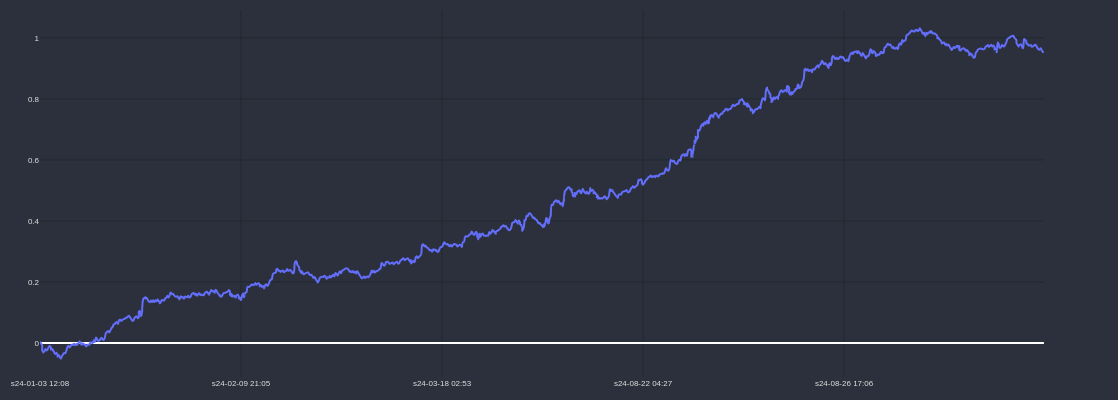

In [108]:

df_test['time'] = df_test['end_time']
df_test['GAIN_C'] = df_test.strategy.cumsum()

cp = CandlePlot(df_test, candles=False)
cp.show_plot(line_traces = ['GAIN_C'])#, sec_traces=['operacoes_simultaneas'])

In [109]:
pos = df_test[df_test['strategy']>0]
neg = df_test[df_test['strategy']<0]

print(len(pos),len(neg), len(pos)/(len(pos)+len(neg)))

613 571 0.5177364864864865


In [110]:
df_test.columns

Index(['running', 'tp', 'sl', 'start_index_m5', 'count', 'trigger_type',
       'strategy', 'strategy_no_tc', 'total_opened', 'first_return',
       'trail_stop_trigger', 'trailing_stop_target', 'trailing_stop_loss',
       'stop_loss', 'type', 'start_price', 'trigger_price', 'SIGNAL_UP',
       'SIGNAL_DOWN', 'result', 'end_time', 'start_time', 'time', 'GAIN_I',
       'operacoes_simultaneas', 'GAIN_C'],
      dtype='object')

In [114]:
import numpy as np
import pandas as pd

def calcular_retorno_dinamico_com_alavancagem(df, saldo_total, alavancagem=1, percentual_capital=10):
    """
    Calcula o retorno acumulado em dólar com controle de reserva, considerando operações simultâneas e mantendo
    o saldo total inalterado até que as operações sejam fechadas. Adiciona incremento de 2% ao capital usado.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo as colunas `start_time`, `end_time`, e `strategy`.
        saldo_total (float): Saldo total inicial disponível para operações.
        alavancagem (float): Fator de alavancagem a ser aplicado nas operações.
        percentual_capital (float): Percentual do saldo total a ser usado em cada operação.

    Retorno:
        pd.DataFrame: DataFrame atualizado com colunas adicionais e métricas.
    """
    # Ordenar o DataFrame pelo tempo de abertura
    df = df.sort_values(by="start_time").reset_index(drop=True)

    # Inicializar arrays e variáveis
    n = len(df)
    capital_usado = saldo_total / percentual_capital
    incremento_percentual = 0.0

    status = np.full(n, "fechada", dtype=object)
    retorno_dolar = np.zeros(n)
    capital_acumulado = np.full(n, saldo_total)
    saldo_total_arr = np.full(n, saldo_total)
    capital_usado_arr = np.zeros(n)

    for i in range(n):
        # Fechar operações cujo end_time já passou
        abertas = (status == "aberta") & (df["end_time"].values <= df["start_time"].iloc[i])
        for j in np.where(abertas)[0]:
            retorno_alavancado = alavancagem * (df["strategy"].iloc[j] * capital_usado_arr[j])
            saldo_total += retorno_alavancado  # Atualizar saldo total com o retorno da operação
            retorno_dolar[j] = retorno_alavancado
            status[j] = "fechada"
            # Recalcular o capital usado após fechar uma operação
            capital_usado = saldo_total / percentual_capital

        # Incrementar o capital usado em 2% para a nova operação
        capital_usado *= (1 + incremento_percentual)
        capital_usado_arr[i] = capital_usado

        # Marcar a operação como aberta
        status[i] = "aberta"

        # Atualizar o saldo acumulado e saldo total
        saldo_total_arr[i] = saldo_total
        capital_acumulado[i] = saldo_total

    # Adicionar os resultados ao DataFrame
    df["capital_usado"] = capital_usado_arr
    df["retorno_dolar"] = retorno_dolar
    df["capital_acumulado"] = capital_acumulado
    df["saldo_total"] = saldo_total_arr
    df["status"] = status

    print("Resumo Final:")
    print(f"Saldo total final: ${saldo_total:.2f}")
    return df


In [115]:
df_test.operacoes_simultaneas.mean()

np.float64(1.0)

In [118]:
# valor_inicial = 5.0
saldo_total = 140.0

# Exemplo de uso com alavancagem
df_resultado_dinamico_alavancagem = calcular_retorno_dinamico_com_alavancagem(
    df_test, saldo_total, alavancagem=10, percentual_capital=1
)

Resumo Final:
Saldo total final: $209574.50


In [119]:
df_test.strategy.sum()

np.float64(0.9546989974208434)

In [121]:
df_resultado_dinamico_alavancagem[["start_time", "end_time", "strategy", "capital_usado", "retorno_dolar",
              "capital_acumulado", "saldo_total"]].head(250)

start_time            end_time  strategy  capital_usado  \
0   2024-01-03 12:07:34 2024-01-03 12:08:20  0.004218     140.000000   
1   2024-01-03 12:09:20 2024-01-03 12:09:42 -0.005362     145.904674   
2   2024-01-03 12:09:58 2024-01-03 12:10:08 -0.006000     138.081182   
3   2024-01-03 12:10:20 2024-01-03 12:10:24 -0.004781     129.796311   
4   2024-01-03 12:10:42 2024-01-03 12:10:44 -0.006000     123.591109   
5   2024-01-03 12:10:54 2024-01-03 12:10:58 -0.006000     116.175643   
6   2024-01-03 12:11:04 2024-01-03 12:11:08 -0.006000     109.205104   
7   2024-01-03 12:11:26 2024-01-03 12:11:26 -0.001000     102.652798   
8   2024-01-03 12:12:40 2024-01-03 12:12:52  0.004060     101.626270   
9   2024-01-03 12:16:48 2024-01-03 12:16:54  0.006996     105.751898   
10  2024-01-04 18:24:32 2024-01-04 18:24:38 -0.004789     113.150813   
11  2024-01-04 18:25:32 2024-01-04 18:25:58  0.004113     107.732546   
12  2024-01-04 18:26:32 2024-01-04 18:30:08  0.007703     112.163970   
13  2024-01-04 19:06:46 2024-01-04 19:07:56  0.003315     120.803675   
14  2024-01-04 19:08:34 2024-01-04 19:08:36 -0.006000     124.808329   
15  2024-01-04 19:08:40 2024-01-04 19:08:46 -0.006000     117.319829   
16  2024-01-04 19:14:06 2024-01-04 19:14:14  0.001880     110.280640   
17  2024-01-04 21:24:02 2024-01-04 21:24:14 -0.005093     112.354426   
18  2024-01-04 21:24:52 2024-01-04 21:25:04 -0.006000     106.632709   
19  2024-01-04 21:25:12 2024-01-04 21:25:20 -0.001000     100.234746   
20  2024-01-04 21:25:52 2024-01-04 21:26:00 -0.004349      99.232399   
21  2024-01-04 21:26:54 2024-01-04 21:27:00  0.004232      94.916716   
22  2024-01-04 21:27:42 2024-01-04 21:27:42 -0.001000      98.933535   
23  2024-01-04 21:28:30 2024-01-04 21:28:32 -0.006000      97.944200   
24  2024-01-04 21:28:50 2024-01-04 21:28:54 -0.006000      92.067548   
25  2024-01-04 21:29:32 2024-01-04 21:29:38  0.005788      86.543495   
26  2024-01-04 21:30:52 2024-01-04 21:31:02 -0.006000      91.552365   
27  2024-01-04 21:32:12 2024-01-04 21:32:30 -0.006000      86.059223   
28  2024-01-04 21:33:36 2024-01-04 21:33:42  0.008269      80.895669   
29  2024-01-04 21:34:34 2024-01-04 21:34:42  0.005834      87.584945   
30  2024-01-04 21:35:04 2024-01-04 21:35:46  0.004692      92.694719   
31  2024-01-04 21:36:18 2024-01-04 21:36:18 -0.001000      97.044111   
32  2024-01-04 21:38:50 2024-01-04 21:40:02  0.008341      96.073670   
33  2024-01-04 21:43:06 2024-01-04 21:44:06  0.011977     104.087370   
34  2024-01-04 22:01:10 2024-01-04 22:01:18  0.004185     116.554327   
35  2024-01-04 22:26:18 2024-01-04 22:26:20 -0.006000     121.432486   
36  2024-01-04 22:29:34 2024-01-04 22:30:10  0.005514     114.146537   
37  2024-01-04 22:43:48 2024-01-04 22:46:06  0.004214     120.440631   
38  2024-01-04 22:55:12 2024-01-04 22:55:12 -0.001000     125.516074   
39  2024-01-04 22:56:18 2024-01-04 22:56:28  0.004141     124.260914   
40  2024-01-04 22:57:10 2024-01-04 22:57:20 -0.005468     129.407054   
41  2024-01-04 22:57:38 2024-01-04 22:58:10  0.004142     122.331572   
42  2024-01-04 22:58:52 2024-01-04 22:58:52 -0.001000     127.398450   
43  2024-01-04 23:02:14 2024-01-04 23:02:14 -0.001000     126.124466   
44  2024-01-04 23:02:34 2024-01-04 23:02:52  0.002242     124.863221   
45  2024-01-04 23:02:58 2024-01-04 23:03:04  0.002005     127.662847   
46  2024-01-04 23:05:02 2024-01-04 23:06:32  0.007074     130.222245   
47  2024-01-04 23:39:18 2024-01-04 23:39:48 -0.006000     139.433603   
48  2024-01-04 23:39:52 2024-01-04 23:40:36 -0.005983     131.067587   
49  2024-01-04 23:41:34 2024-01-04 23:41:46  0.004952     123.225609   
50  2024-01-04 23:45:56 2024-01-04 23:46:04 -0.003121     129.328232   
51  2024-01-04 23:49:24 2024-01-04 23:49:24 -0.001000     125.292038   
52  2024-01-05 00:45:28 2024-01-05 00:45:36 -0.006000     124.039118   
53  2024-01-05 00:45:52 2024-01-05 00:46:26  0.004091     116.596771   
54  2024-01-05 01:01:12 2024-01-05 01:01:50  0.002555

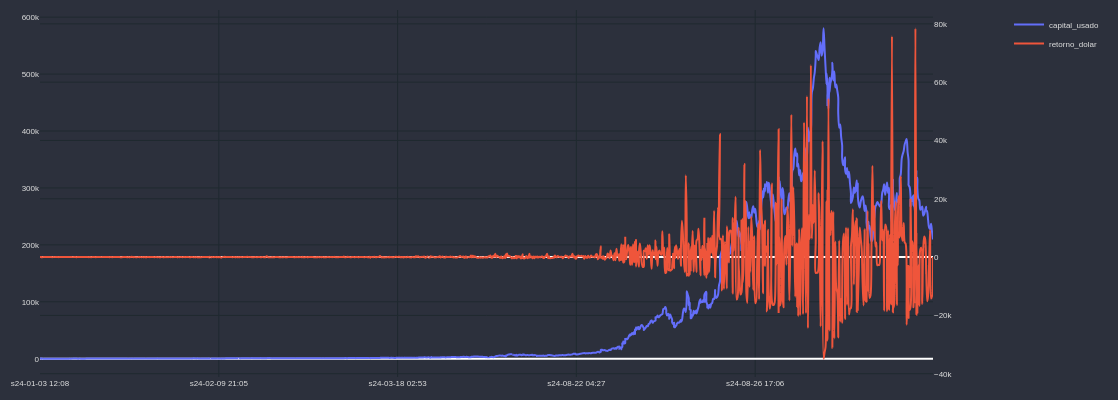

In [122]:
cp = CandlePlot(df_resultado_dinamico_alavancagem, candles=False)
cp.show_plot(line_traces = ['capital_usado'], sec_traces=['retorno_dolar'])

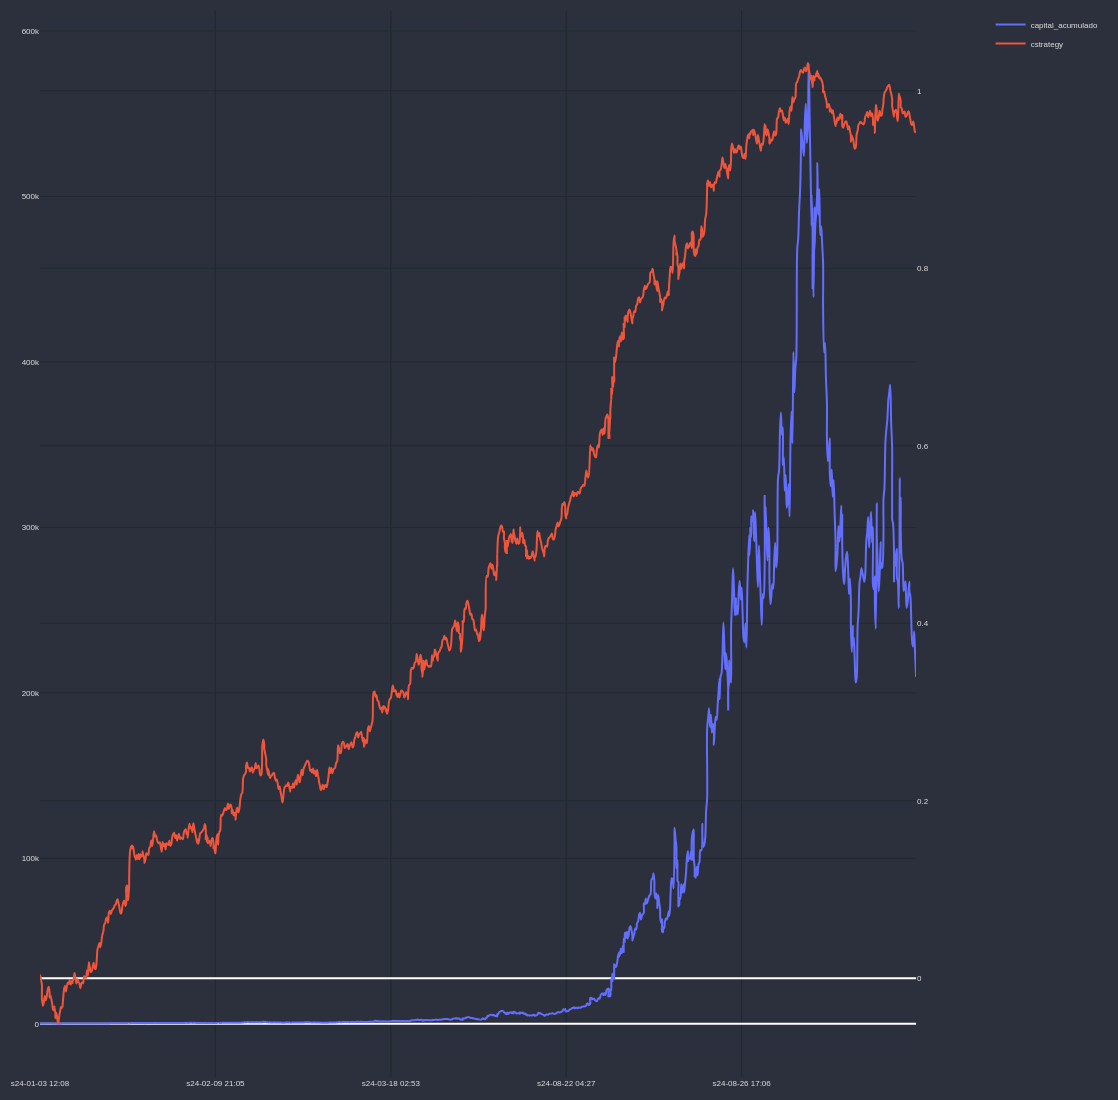

In [124]:
df_resultado_dinamico_alavancagem['cstrategy'] = df_resultado_dinamico_alavancagem.strategy.cumsum()
cp = CandlePlot(df_resultado_dinamico_alavancagem, candles=False)
cp.show_plot(line_traces = ['capital_acumulado'], sec_traces=['cstrategy'], height=1100)